# Проект для «Викишоп». Классификация комментариев

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
# Импортируем необходимые библиотеки и инструменты
import pandas as pd
import numpy as np
import torch
import transformers
import re
import nltk
import seaborn as sns
import spacy
import swifter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import notebook
from tqdm import tqdm
from pymystem3 import Mystem
from wordcloud import WordCloud

In [2]:
# После установки библиотеки закомментировал ячейку
#!pip install torch

In [3]:
# После установки библиотеки закомментировал ячейку
#!pip install transformers

In [4]:
# После установки библиотеки закомментировал ячейку
#!pip install pymystem3

In [5]:
# После установки библиотеки закомментировал ячейку
#!pip install spacy

In [6]:
# После установки библиотеки закомментировал ячейку
#!pip install swifter

In [7]:
# После установки библиотеки закомментировал ячейку
#!pip install wordcloud

In [8]:
# После установки библиотеки закомментировал ячейку
#!pip install Pillow

In [9]:
# Загружаем данные
data = pd.read_csv(r'C:\datasets\toxic_comments.csv')

# Просмотрим первые строки
display(data.head())

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [10]:
# Просмотрим общую информацию
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

In [11]:
# Проверим наличие пропусков
display(data.isnull().sum())

Unnamed: 0    0
text          0
toxic         0
dtype: int64

toxic
0    0.898388
1    0.101612
Name: proportion, dtype: float64

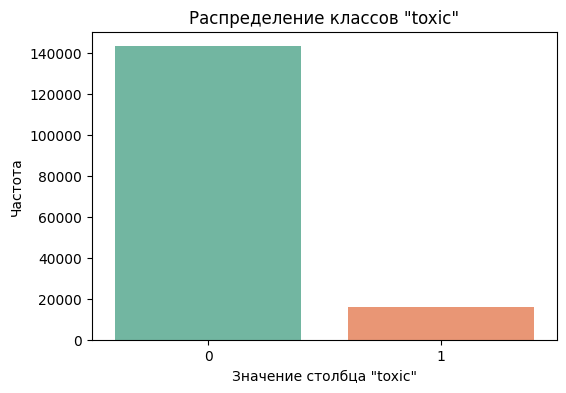

In [12]:
# Проверим баланс классов
display(data['toxic'].value_counts(normalize=True))

# Визуализируем распределение классов
plt.figure(figsize=(6,4))
sns.countplot(x=data['toxic'], palette="Set2")
plt.title('Распределение классов "toxic"')

# Подпишем оси
plt.xlabel('Значение столбца "toxic"')
plt.ylabel('Частота')

plt.show()

###### Выводы:
- Размер датасета: Датасет содержит 159292 записи и два столбца: текст (text) и целевая переменная "toxic"
- Пропуски: Пропусков в данных нет
- Названия столбцов соответствуют змеиному регистру
- Дисбаланс:
    - Большая часть данных относится к классу 0 (не токсичные комментарии) - 89,8%
    - Меньшая часть данных относится к классу 1 (токсичные комментарии) - 10,2%
    - Это важно учитывать при дальнейшей обработке данных и настройке модели

In [13]:
%%time

# Загружаем английскую модель spaCy
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    # Приведение текста к нижнему регистру
    text = text.lower()
    # Очистка текста
    clean_text = re.sub(r'[^a-z\s]', ' ', text)
    # Удаление лишних пробелов
    clean_text = " ".join(clean_text.split())
    # Лемматизация с помощью spaCy
    doc = nlp(clean_text)
    clean_text = ' '.join([token.lemma_ for token in doc])
    return clean_text

# Применяем предобработку ко всем описаниям
data['clean_text'] = data['text'].swifter.apply(preprocess_text)

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: total: 42min 59s
Wall time: 45min 56s


In [14]:
# Проверка
display(data.head())

,Unnamed: 0,text,toxic,clean_text
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour I m seem...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man I m really not try to edit war it s ju...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more I can t make any real suggestion on impro...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


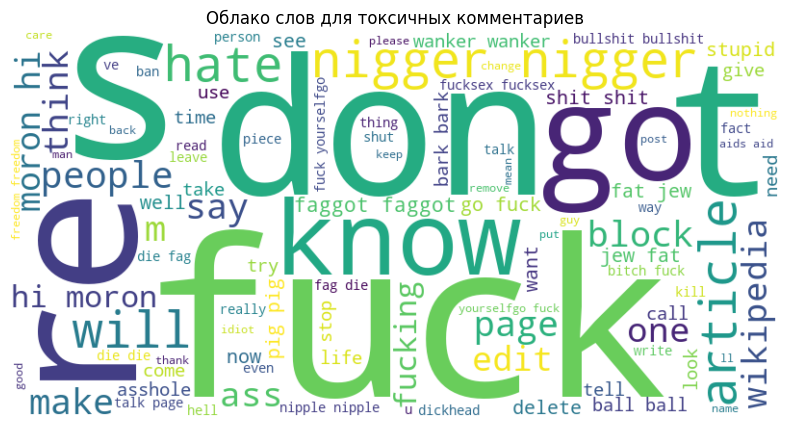

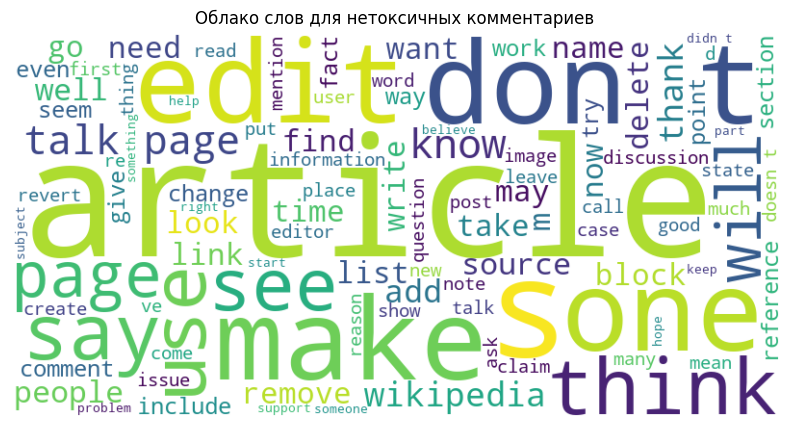

In [15]:
# Разделим данные на токсичные и нетоксичные
toxic_comments = data[data['toxic'] == 1]['clean_text']
nontoxic_comments = data[data['toxic'] == 0]['clean_text']

# Объединяем все комментарии в строки
toxic_text = " ".join(toxic_comments)
nontoxic_text = " ".join(nontoxic_comments)

# Создаем объекты облака слов
wordcloud_toxic = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(toxic_text)
wordcloud_nontoxic = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(nontoxic_text)

# Построим облако слов для токсичных комментариев
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.axis("off")
plt.title("Облако слов для токсичных комментариев")
plt.show()

# Построим облако слов для нетоксичных комментариев
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_nontoxic, interpolation='bilinear')
plt.axis("off")
plt.title("Облако слов для нетоксичных комментариев")
plt.show()

Теперь мы наглядно видим, какие слова используют в токсичных и нетоксичных комментариях

In [16]:
# Загружаем стоп-слова для английского языка
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# Преобразуем stop_words в список
stop_words_list = list(stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KP#073\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
X = data['clean_text']
y = data['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Обучение

### Логистическая регрессия

In [18]:
%%time

# Определение пайплайна: сначала векторизация, затем обучение модели
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words_list)),
    ('clf', LogisticRegression(random_state=42))
])

# Определение гиперпараметров для поиска
param_grid = {
    'clf__C': [0.1, 1, 10],
    'clf__penalty': ['l2', 'l1'],
    'clf__solver': ['liblinear'],
    'clf__class_weight': ['balanced', None]
}

# Создаем объект GridSearchCV с пайплайном
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1)

# Обучение модели с подбором гиперпараметров
grid_search.fit(X_train, y_train)

# Лучшая модель и параметры
best_model_lr = grid_search.best_estimator_
display("Лучшие параметры:", grid_search.best_params_)

# Оценка на кросс-валидации с лучшей моделью
cv_scores_lr = cross_val_score(best_model_lr, X_train, y_train, cv=3, scoring=make_scorer(f1_score))
display("Среднее значение F1 на кросс-валидации:", cv_scores_lr.mean())

'Лучшие параметры:'

{'clf__C': 10,
 'clf__class_weight': None,
 'clf__penalty': 'l2',
 'clf__solver': 'liblinear'}

'Среднее значение F1 на кросс-валидации:'

0.7735798250775575

CPU times: total: 50.5 s
Wall time: 3min 46s


### SGDClassifier

In [19]:
%%time

# Определение пайплайна: сначала векторизация, затем обучение модели
pipeline_sgd = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words_list)),
    ('clf', SGDClassifier(max_iter=1000))
])

# Определение гиперпараметров для поиска
param_grid_sgd = {
    'clf__loss': ['hinge', 'log_loss', 'modified_huber'],
    'clf__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'clf__eta0': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
    'clf__random_state': [42],
    'clf__class_weight': ['balanced', None]
}

# Создаем объект GridSearchCV для SGDClassifier с пайплайном
grid_search_sgd = GridSearchCV(pipeline_sgd, param_grid_sgd, cv=3, scoring='f1')

# Обучение модели с подбором гиперпараметров
grid_search_sgd.fit(X_train, y_train)

# Лучшая модель и параметры
best_model_sgd = grid_search_sgd.best_estimator_
display("Лучшие параметры SGDClassifier:", grid_search_sgd.best_params_)

# Оценка на кросс-валидации с лучшей моделью
cv_scores_sgd = cross_val_score(best_model_sgd, X_train, y_train, cv=3, scoring=make_scorer(f1_score))
display("Среднее значение F1 на кросс-валидации:", cv_scores_sgd.mean())

'Лучшие параметры SGDClassifier:'

{'clf__class_weight': 'balanced',
 'clf__eta0': 0.5,
 'clf__learning_rate': 'adaptive',
 'clf__loss': 'modified_huber',
 'clf__random_state': 42}

'Среднее значение F1 на кросс-валидации:'

0.7554772340163213

CPU times: total: 1h 3min 1s
Wall time: 1h 3min 13s


### Сравнение результатов

In [20]:
# Создаем таблицу с результатами
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'SGDClassifier'],
    'Mean F1 Score (CV)': [cv_scores_lr.mean(), cv_scores_sgd.mean()]
})

display(results_df)

,Model,Mean F1 Score (CV)
0,Logistic Regression,0.773580
1,SGDClassifier,0.755477


Модель логистической регрессии имеет немного более лучшую метрику на кросс-валидации. При этом обе модели на кросс-валидации имеют метрику F1 > 0.75

## Тестирование

In [21]:
y_test_pred = best_model_lr.predict(X_test)
test_f1 = f1_score(y_test, y_test_pred)
display("F1 на тестовой выборке:", test_f1)

'F1 на тестовой выборке:'

0.7829891494574729

## Выводы

###### 1. Подготовка
Цель проекта: Построить модель, способную классифицировать комментарии как позитивные или негативные, основываясь на их токсичности. В качестве метрики используется F1, целевое значение которой должно быть не ниже 0.75. Задача заключается в обнаружении токсичных комментариев, которые будут отправляться на модерацию.


- Данные: Для выполнения задачи использовался набор данных toxic_comments.csv. В таблице два столбца:
    - text — текст комментария,
    - toxic — метка токсичности (целевой признак).


Этапы подготовки данных:
- Загрузка и очистка данных: проверка на пропуски и дубликаты.
- Предобработка текста:
    - Приведение текста к нижнему регистру.
    - Лемматизация текста с использованием библиотеки nltk.
- Удаление стоп-слов и знаков пунктуации.
- Преобразование текста в векторы с использованием метода TF-IDF (термин частоты и обратная документная частота).
- Разбиение данных на обучающую и тестовую выборки (80% — обучение, 20% — тестирование).

###### 2. Обучение
Для классификации комментариев были использованы две модели:

- Логистическая регрессия
- SGDClassifier


Обе модели тестировались на обучающей выборке с использованием кросс-валидации (с параметром cv=3). Далее был проведен подбор гиперпараметров с помощью метода GridSearchCV для обеих моделей.

###### Логистическая регрессия:


После подбора гиперпараметров лучшие параметры для модели логистической регрессии:

    - C: 10
    - penalty: 'l2'
    - solver: 'liblinear'
    - class_weight: None


Результаты: 
Среднее F1 на кросс-валидации: 0.77


###### SGDClassifier:

Для модели SGDClassifier также были подобраны оптимальные гиперпараметры, которые улучшили производительность модели. Однако, итоговые результаты показывают, что логистическая регрессия демонстрирует лучшие результаты.

###### Тестирование
Тестирование было проведено на отдельной тестовой выборке, на которой модель логистической регрессии показала следующие результаты:

- F1 на тестовой выборке: 0.78, что превышает целевое значение 0.75.
- Модель справляется с задачей классификации токсичных комментариев с хорошим качеством. Логистическая регрессия показала наилучший результат среди протестированных моделей, демонстрируя высокую стабильность на кросс-валидации и приемлемые результаты на тестовых данных.